In [1]:
!nvidia-smi

Sat Nov 17 14:07:39 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   35C    P0    54W / 300W |  13434MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:1C:00.0 Off |                    0 |
| N/A   31C    P0    41W / 300W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [1]:
import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize

import pydicom
from pydicom.data import get_testdata_files

import os
from tensorboardX import SummaryWriter

from datasets import Brains
from modules import Conv2D1, ConvTranspose2D1
from models import UNet3D

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
data = Brains(crop_size=(64,64))
batch_size = 2
datait = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=20)

In [5]:
for i in datait:
    print(i)
    break

[tensor([[[[[  16.,   11.,    9.,  ...,   13.,    8.,    3.],
           [  18.,   19.,   18.,  ...,   14.,   11.,    5.],
           [  12.,   22.,   26.,  ...,   11.,    8.,    4.],
           ...,
           [   9.,   11.,   14.,  ...,   12.,   21.,   21.],
           [   5.,    5.,    6.,  ...,    6.,   11.,   14.],
           [   4.,    3.,    1.,  ...,   17.,   10.,    3.]],

          [[  17.,   12.,   11.,  ...,   15.,   15.,   14.],
           [  11.,   15.,   24.,  ...,   21.,   17.,   19.],
           [  16.,   10.,   31.,  ...,   20.,   14.,   12.],
           ...,
           [  11.,   16.,   20.,  ...,  287.,  327.,  357.],
           [   3.,    7.,   17.,  ...,  307.,  353.,  379.],
           [   4.,    6.,   19.,  ...,  335.,  393.,  420.]],

          [[   4.,    2.,    1.,  ...,   16.,   19.,   21.],
           [  13.,    7.,    5.,  ...,   15.,   19.,   22.],
           [  24.,   21.,   11.,  ...,   14.,   26.,   34.],
           ...,
           [  17.,   15.,   12.,

In [9]:
i[0].

torch.Size([2, 1, 22, 64, 64])

In [5]:
baseline_unet = UNet3D(input_nc=1, output_nc=2).cuda()

In [6]:
baseline_unet.load_state_dict(torch.load("safin_model"))

In [7]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.,25.]).float()).cuda()
opt = torch.optim.Adam(baseline_unet.parameters(), lr=1e-4)
epoch = 0
train_loss = []



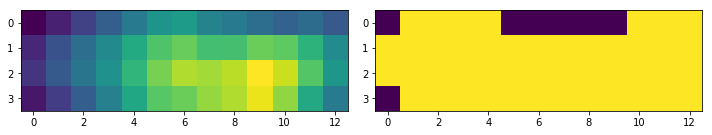

In [98]:
i = 3
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(data[0][0][0,i][i_arr.min():i_arr.max(), j_arr.min():j_arr.max()])
plt.subplot(2,2,2)
plt.imshow(data[0][1][0,i][i_arr.min():i_arr.max(), j_arr.min():j_arr.max()])
plt.tight_layout()

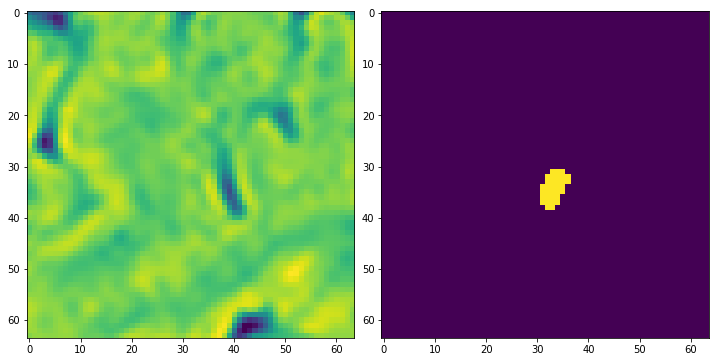

In [9]:
i = 2
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(data[0][0][0,i])
plt.subplot(2,2,2)
plt.imshow(data[0][1][0,i])
plt.tight_layout()

In [8]:
def dice_score(input, target):
    smooth = 1e-3
    iflat = input.reshape((input.size(0),-1))
    tflat = target.reshape((target.size(0),-1))
    intersection = (iflat * tflat).sum(1)
    
    return ((2. * intersection + smooth) / (iflat.sum(1) + tflat.sum(1)-intersection + smooth))

In [9]:
log_folder_path = "../logs/"
writer = SummaryWriter(log_folder_path) #or we could put the name of experiment

In [10]:
i = 0
while True:
    print("Epoch", epoch)
    baseline_unet.train(True)
    
    epoch_loss = []
    
    for X_batch, masks_batch in datait:
#         X_batch = X_batch[0]
        probs = baseline_unet(X_batch.cuda())
        _, preds = probs.max(dim=1, keepdim=True)

#         print(preds.shape, masks_batch.shape)
        loss = criterion(probs, masks_batch.squeeze(1).cuda())
        writer.add_scalar('Cross entropy loss', loss.item(), i)
        dice = dice_score(preds.float(), masks_batch.squeeze(1).cuda().float()).mean()
        writer.add_scalar('Dice score', dice.item(), i)
#         print(X_batch.shape)
#         print(torchvision.utils.make_grid(X_batch).shape)
        bool_mask, idx = masks_batch.reshape((*masks_batch.shape[:3],-1)).max(dim=-1)
        if torch.any(bool_mask.reshape((1,-1)).byte()==1):
            writer.add_image('Input image vs mask vs pred', torch.cat((X_batch[bool_mask.byte()][0], masks_batch[bool_mask.byte()][0].float(), preds[bool_mask.byte()][0].cpu().float()), dim=1), i)
        
#         score = dice_score(F.threshold(preds, 0.5, 1), masks_batch)
        
        # train on batch
        opt.zero_grad()
        loss.backward()
        opt.step()
        i += 1
        
        epoch_loss.append(loss.cpu().data.numpy())

    train_loss.append(np.mean(epoch_loss))

    display.clear_output(wait=True)

    plt.clf()
    plt.plot(train_loss[-100:])
    plt.title('Train loss')
    plt.show()
#         display.display(plt.gcf())

    epoch += 1

Epoch 0


RuntimeError: Input type (torch.cuda.DoubleTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [29]:
(masks_batch.cuda()*preds).reshape((preds.size(0),-1)).sum(1)

tensor([2193,    0], device='cuda:0')

In [30]:
def dice_score(input, target):
    smooth = 1e-3
    iflat = input.reshape((input.size(0),-1))
    tflat = target.reshape((target.size(0),-1))
    intersection = (iflat * tflat).sum(1)
    
    return ((2. * intersection + smooth) / (iflat.sum(1) + tflat.sum(1)-intersection + smooth))

In [15]:
masks_batch.shape

torch.Size([2, 1, 24, 64, 64])

In [11]:
torch.save(baseline_unet.state_dict(), "safin_model")

In [32]:
dice_score(preds.float(), masks_batch.squeeze(1).cuda().float())

tensor([5.7642e-01, 9.7324e-08], device='cuda:0')

In [12]:
dice_score(preds, masks_batch.squeeze(1).cuda())

tensor(0, device='cuda:0')

In [ ]:
def dice_loss(input, target):
    smooth = 1e-3
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1-((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))